# Plot combined approach results

Notebook to plot and explore results from the combined VMEC + simsopt optimization 

In [1]:
import os
from pathlib import Path
from simsopt._core.optimizable import load
import matplotlib.pyplot as plt
import numpy as np
from simsopt.geo import SurfaceRZFourier
from simsopt.mhd import Vmec, QuasisymmetryRatioResidual
from simsopt.field import compute_fieldlines, LevelsetStoppingCriterion, SurfaceClassifier, plot_poincare_data
%matplotlib widget
import pickle

In [14]:
# Load data
dirname = 'stage_1_mpol=ntor=3'
#date = '2023-10-17T15:03:34'
directory = 'runs/' + dirname
parent_path = '.'
this_path = os.path.join(parent_path, directory)
os.chdir(parent_path)
vmec_dir = os.path.join(this_path, "vmec")
coil_dir = os.path.join(this_path, "coils")
figure_path = os.path.join(this_path, 'figures')
os.makedirs(figure_path, exist_ok=True)

wout_file = os.path.join(this_path, "wout_final.nc")
vmec = Vmec( wout_file )
initial_vmec = Vmec( 'vmec_inputs/wout_tokamak.nc' ) 
initial_bs = load( 'flux_100_bs_cssc_cssc.json' )
bs = load(os.path.join(this_path,"coils/bs_output.json"))

In [15]:
vmec.wout.fsqr

9.828349817343708e-13

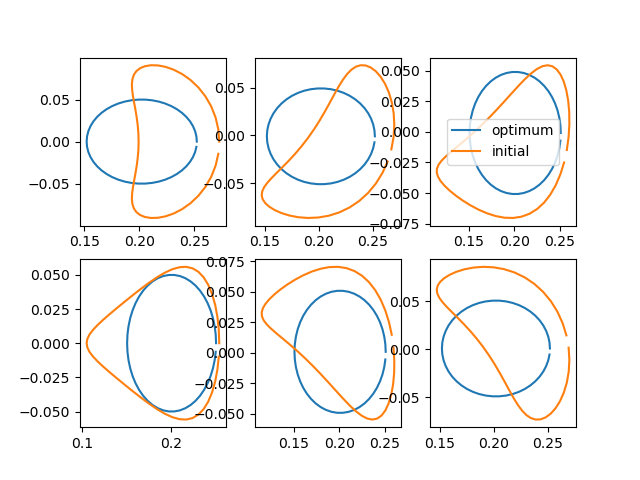

In [24]:
# Plot some cross sections
fig, ax = plt.subplots(2,3)
for phi, aa in zip(np.linspace(0,np.pi,6,endpoint=False), ax.flatten()):
    for v, l in zip([initial_vmec, vmec], ['initial', 'optimum']):
        cs = v.boundary.cross_section(phi=phi)
        R = np.sqrt(cs[:,0]**2 + cs[:,1]**2)
        Z = cs[:,2]
        aa.plot(R,Z)
ax[0,2].legend({'optimum', 'initial'})
plt.savefig(os.path.join(figure_path, 'cross_sections.png'))

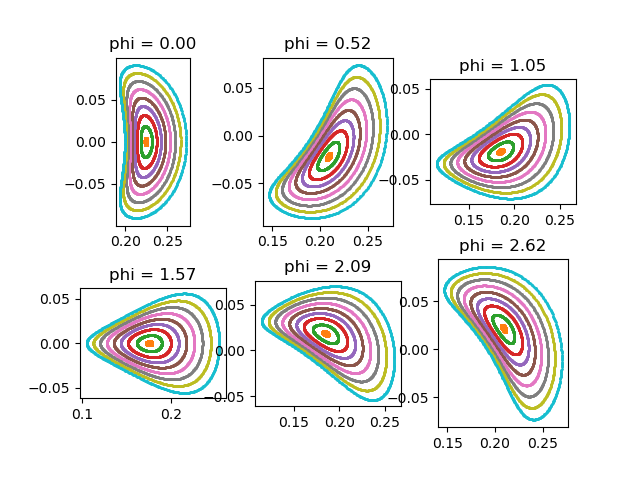

In [17]:
# Plot VMEC Poincare section
fig, ax = plt.subplots(2,3)
ns = 10
nt = 512
surfaces = [SurfaceRZFourier.from_wout(wout_file, s=s) for s in np.linspace(0.0,1,ns)**2]
theta = np.linspace(0,2*np.pi,nt)
for phi, aa in zip(np.linspace(0,np.pi,6,endpoint=False), ax.flatten()):
    for s in surfaces:
        R = np.zeros((nt,))
        Z = np.zeros((nt,))
        mpol = s.mpol
        ntor = s.ntor
        for mm in range(0,mpol+1):
            for nn in range(-ntor,ntor+1):
                if mm==0 and nn<0: continue
                rc = s.rc[mm,ntor+nn]
                zs = s.zs[mm,ntor+nn]
                R += rc * np.cos(mm*theta - nn*s.nfp*phi)
                Z += zs * np.sin(mm*theta - nn*s.nfp*phi)
    
        aa.scatter(R,Z,s=1)

    aa.set_title('phi = {:.2f}'.format(phi))
    aa.set_aspect('equal')
plt.savefig(os.path.join(figure_path, 'vmec_poincare_section.png'))

In [6]:
nfieldlines = 100
tmax_fl = 1000
degree = 4
Rmaj = vmec.boundary.major_radius()
r0 = vmec.boundary.minor_radius()
vmec_surf_1 = SurfaceRZFourier.from_wout(wout_file) # Expanded vmec surface
vmec_surf_1.extend_via_normal(0.1)
sc_fieldline = SurfaceClassifier(vmec_surf_1, h=0.01, p=3)

def trace_fieldlines(bfield,label):
    # Set up initial conditions - 
    R0 = np.linspace(Rmaj-2*r0, Rmaj+2*r0, nfieldlines)
    Z0 = np.zeros(nfieldlines)
    phis = [(i/4)*(2*np.pi/vmec.boundary.nfp) for i in range(4)]
    fieldlines_tys, fieldlines_phi_hits = compute_fieldlines(
        bfield, R0, Z0, tmax=tmax_fl, tol=1e-8,
        phis=phis, stopping_criteria=[LevelsetStoppingCriterion(sc_fieldline.dist)])

    plot_poincare_data(
        fieldlines_phi_hits, phis, 
        os.path.join(figure_path, f'poincare_fieldline.{date}.png'), 
        dpi=150,surf=vmec.boundary,mark_lost=False
    )
    return fieldlines_phi_hits

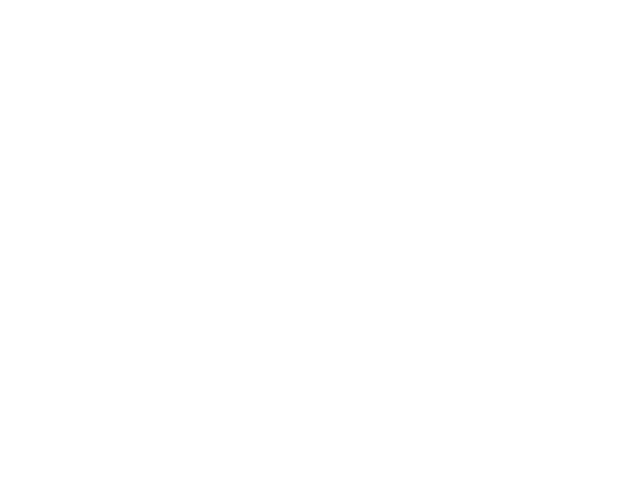

In [6]:
hits = trace_fieldlines(bs, 'vmec')

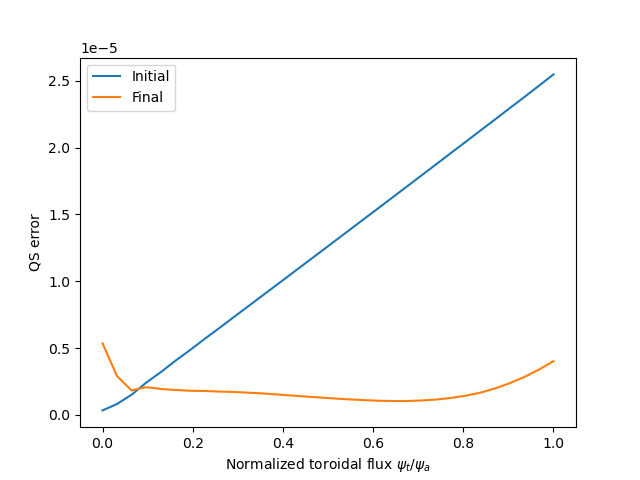

In [18]:
quasisymmetry_target_surfaces = np.linspace(0,1,32,endpoint=True)
qs = QuasisymmetryRatioResidual(vmec, quasisymmetry_target_surfaces, helicity_m=1, helicity_n=0)
in_qs = QuasisymmetryRatioResidual(initial_vmec, quasisymmetry_target_surfaces, helicity_m=1, helicity_n=0)

plt.figure()
plt.plot(quasisymmetry_target_surfaces, in_qs.profile(), label='Initial')
plt.plot(quasisymmetry_target_surfaces, qs.profile(), label='Final')
plt.legend()
plt.xlabel(r'Normalized toroidal flux $\psi_t/\psi_a$')
plt.ylabel('QS error')


plt.savefig(os.path.join(figure_path, 'qs_profile.png'))

(-1.0, 1.0)

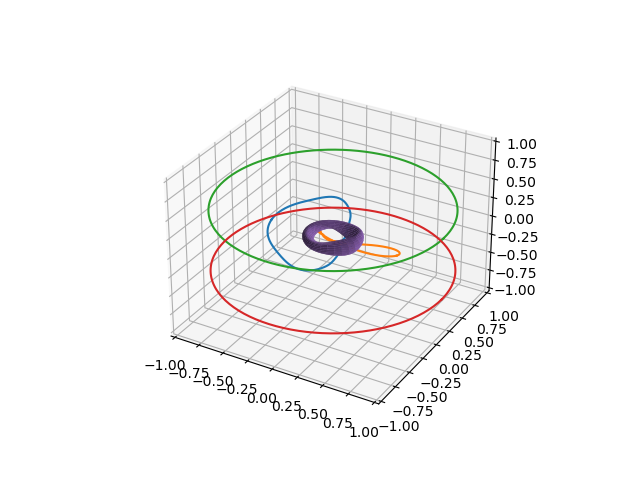

In [19]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for c in bs.coils:
    c.curve.plot(ax=ax,close=True,show=False)
vmec.boundary.plot(ax=ax,close=True,show=False)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

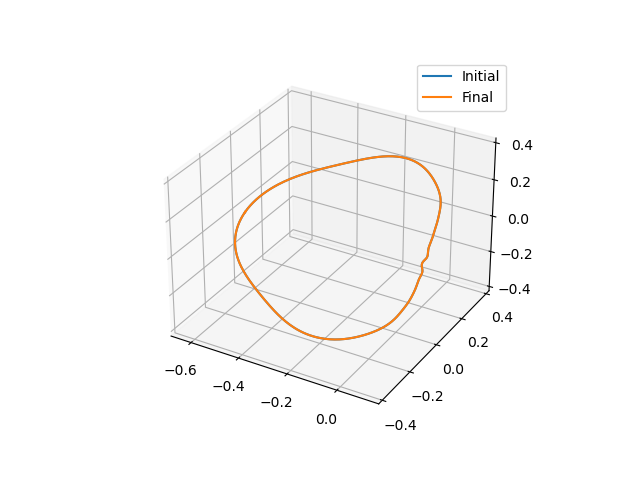

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
initial_bs.coils[0].curve.plot(ax=ax, close=True, show=False, label='Initial')
bs.coils[0].curve.plot(ax=ax, close=True, show=False, label='Final')
plt.legend()

plt.savefig(os.path.join(figure_path, 'il_coil_before_after.png'))

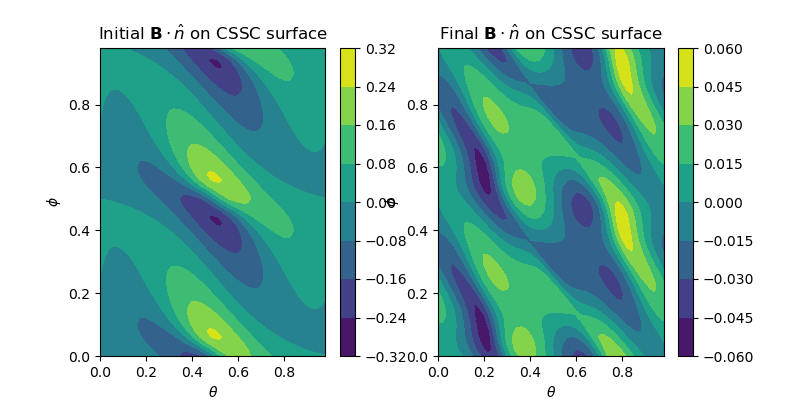

In [22]:
surf = vmec.boundary
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(8,4))
for ax, bb , v in zip(axs, [initial_bs, bs], [initial_vmec, vmec]):
    s = v.boundary
    bb.set_points(s.gamma().reshape((-1,3)))
    Bdotn = np.sum(bb.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)
    ax.set_ylabel(r'$\phi$')
    ax.set_xlabel(r'$\theta$')
    c = ax.contourf(theta,phi,Bdotn)
    plt.colorbar(c)


axs[0].set_title(r'Initial $\mathbf{B}\cdot\hat{n}$ on CSSC surface')
axs[1].set_title(r'Final $\mathbf{B}\cdot\hat{n}$ on CSSC surface')
plt.savefig(os.path.join(figure_path, 'normal_field_error.png'))

In [23]:
with open(os.path.join(this_path, 'outputs.pckl'), 'rb') as f:
    outputs = pickle.load(f)
try:
    with open(os.path.join(this_path, 'input.pckl'), 'rb') as f:
        input = pickle.load(f)
except FileNotFoundError:
    try:
        import runs.combined_approach_staged_3.input as input
        input = input.inputs
    except FileNotFoundError:
        print('Input file not found!')
#outputs['result'].message

FileNotFoundError: [Errno 2] No such file or directory: './runs/stage_1_mpol=ntor=3/outputs.pckl'

NameError: name 'outputs' is not defined

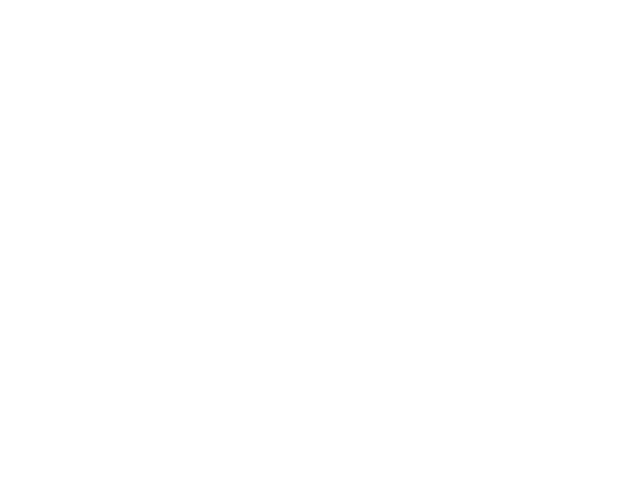

In [11]:
plt.figure()
plt.semilogy(outputs['J'],linewidth=3,label='J')
plt.semilogy(outputs['Jplasma'],'--',linewidth=3,label='Jplasma')
plt.semilogy(outputs['Jcoils'],linewidth=3,label='Jcoils')
plt.gca().set_ylim(top=1e5)
plt.legend()
plt.savefig(os.path.join(figure_path, 'objective_function.png'))

'float' object has no attribute 'reshape'


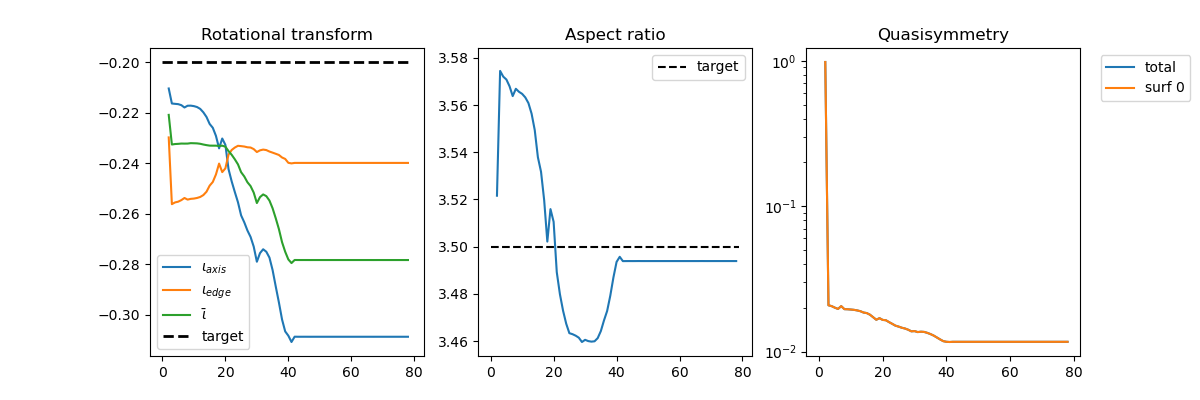

In [13]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
nsteps = len(outputs['mean_iota'])
axs[0].plot(outputs['iota_axis'],label=r'$\iota_{axis}$')
axs[0].plot(outputs['iota_edge'],label=r'$\iota_{edge}$')
axs[0].plot(outputs['mean_iota'],label=r'$\bar\iota$')
axs[0].plot([0,nsteps], np.array([1,1])*input['vmec']['target']['iota'], 'k--', linewidth=2, label='target')
axs[0].legend()
axs[0].set_title('Rotational transform')

axs[1].plot(outputs['aspect'])
axs[1].plot([0,nsteps], np.array([1,1])*input['vmec']['target']['aspect_ratio'], 'k--', label='target')
axs[1].legend()
axs[1].set_title('Aspect ratio')

total = []
nphi = 64
ntheta = 63
ns = input['vmec']['target']['qa_surface'].size
profile = np.zeros((ns,nsteps))
for ii, qs in enumerate(outputs['QSresiduals']):
    try:
        residuals3d = qs.reshape((ns,ntheta,nphi))
        profile[:,ii] = np.sum(residuals3d * residuals3d, axis=(1, 2))
        total.append(np.sum(qs * qs))
    except BaseException as e:
        print(e)
        profile[:,ii] = np.nan
        total.append(np.nan)
axs[2].semilogy(total, label='total')
for isurf in range(0,ns):
    axs[2].semilogy(profile[isurf,:],label=f'surf {isurf}')
axs[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[2].set_title('Quasisymmetry')

plt.savefig(os.path.join(figure_path, 'plasma_targets.png'))

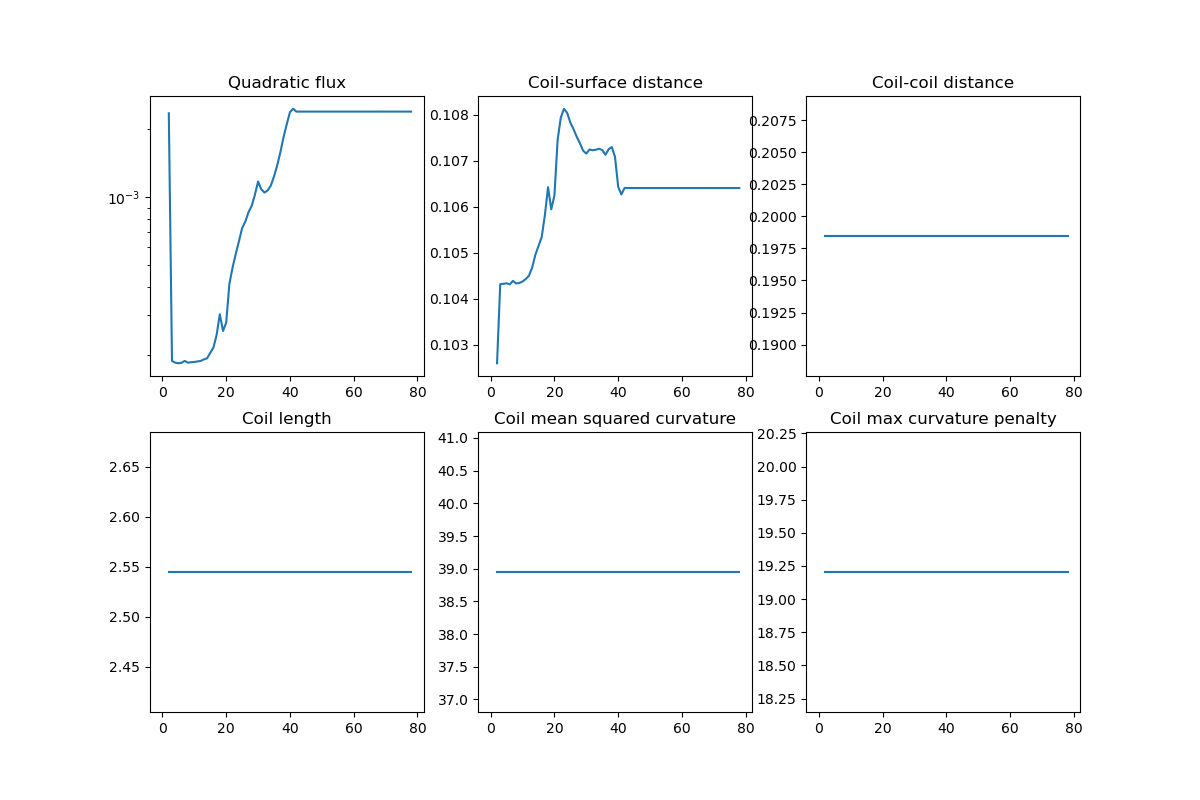

In [14]:
fig, axs=plt.subplots(2,3, figsize=(12,8))
axs[0,0].semilogy(outputs['QuadFlux'])
axs[0,0].set_title('Quadratic flux')

axs[0,1].plot(outputs['min_CS'])
axs[0,1].set_title('Coil-surface distance')

axs[0,2].plot(outputs['min_CC'])
axs[0,2].set_title('Coil-coil distance')

axs[1,0].plot(outputs['IL_length'])
for l in outputs['WP_length']:
    axs[1,0].plot(l)
axs[1,0].set_title('Coil length')

axs[1,1].plot(outputs['IL_msc'])
for l in outputs['WP_msc']:
    axs[1,1].plot(l)
axs[1,1].set_title('Coil mean squared curvature')

axs[1,2].plot(outputs['IL_max_curvature'])
for l in outputs['WP_max_curvature']:
    axs[1,2].plot(l)
axs[1,2].set_title('Coil max curvature penalty')

plt.savefig(os.path.join(figure_path, 'coil_targets.png'))